# Uncertainty in machine learning predictions #

There is inherent uncertainty in machine learning due to statistical nature of most of its algorithms. One of the sources of this uncertainty is incorrect labels either due to data mistakes or the cases when it is difficult to determine the correct label even to the human. For example, in the regression type of problem we can model our prediction as:

$$y = f(x) + \epsilon $$ 

Here $\epsilon$ is the inherent uncertainty in the target. Assuming it follows Normal distribution, we can write the one case's contribution to the likelihood function as:

$$ 
\begin{equation}
p(y|x, \theta, \sigma) \propto e^{-\frac{(y-\theta x)^2}{2\sigma^2}} 
\end{equation}
$$

Here we assumed for simplicity linear regression

The likelihood function is the product of such values, and the negative log of the likelihood function gives us the cost function:

$$
\begin{equation}
\mathscr{L} = \sum_i (y^{(i)} - \theta x^{(i)})^2 
\end{equation}
$$ 


Curiously enough, the uncertainty information has disappeared from the cost function. This is very common for the maximum posterior methods. To estimate degree of uncertainty using data we have to use more powerful methods, like [Bayesian Linear Regression](https://en.wikipedia.org/wiki/Bayesian_linear_regression).


The assumption is that the uncertainty $\sigma$ is the same for all cases. What if it is not? The person who labels the data set can indicate that he is not sure about a given example. For example, unusually low yield on a given bond given its rating, unusually high volume or something that makes the labeler suspect there is an error. For computer vision problems, it can be that someone is having hard time distinguishing 1 from 7 in a given mnist example.

A very common approach is to drop these records. But what if we would like to use this information instead, just not trust it too much.

In case of linear regression model we can indicate increased uncertainty by increasing $\sigma$. For convenience reason, we multiply the exponent in (1) by the precision $\tau$:

$$ p(y|x, \theta, \sigma) \propto e^{-\frac{(y-\theta x)^2\tau}{2\sigma^2}} $$

$\tau$ of 1 indicate the regular level of trust, whereas the lower values of $\tau$ will indicate increased uncertainty. To demonstrate this, let's plot both curves.

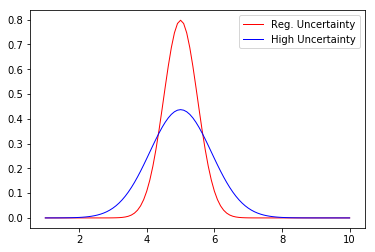

In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def linreg_likelihood(x, y, theta, sigma, tau):
    return np.exp(-(y-theta*x)**2 * tau/2/sigma**2)/np.sqrt(2*np.pi*sigma**2/tau)

fig, ax = plt.subplots(1, 1)
y = np.linspace(1, 10, 100)
ax.plot(y, linreg_likelihood(5,y,1,0.5,1), 'r-', lw=1, alpha=1, label='Reg. Uncertainty')
ax.plot(y, linreg_likelihood(5,y,1,0.5,0.3), 'b-', lw=1, alpha=1, label='High Uncertainty')
plt.legend();


We see, that the example with a higher uncertainty results in a wider distribution, because we are not sure of the target value. If we feed this back to the cost function (2) we will have a corrected cost function:

$$ \mathscr{L} = \sum_i {(y^{(i)} - \theta x^{(i)})^2 \tau^{(i)}} $$

Here $\tau^{(i)}$ is a relative precision of the i-th example. In reality, most of them will be 1, but the labeler can lower $\tau^{(i)}$ for some of the  suspicious examples in the data set.

Having the unusual loss function should not be a problem, because the frameworks, like TensorFlow, provide automatic computation of gradients.

## Uncertainty in binary classification ##
For the binary classification problem we have to use [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution) instead of Normal distribution. 

$$ 
p(k ; \rho) = \rho^k (1-\rho)^{1-k} \tag{3}
$$

Where $\rho$ is the parameter of the distribution and $k\in{0,1}$

Since there is only one parameter of the distribution, there is no way to change the variance without changing the mean. Also there is no obvious way to indicate the uncertainty by increasing variance.


Instead we will derive the equation based on the Bayesian probability concepts. In our case k is the observed outcome, whereas the true target value t may be different from k. We can formalize it with another Bernoulli distribution:

$$ p(k|t;a) = a^{\delta_{kt}} (1-a)^{(1-\delta_{kt})} \tag{4}$$ 

Here $\delta$ is the Kronecker symbol, and $a \in [0.5,1]$ is the degree of uncertainty. If a=1 we are absolutely sure of the label. The case a=0.5 is also an extreme case, when we say we do not trust the label at all.

Then the probability of the observed value given the $\rho$ and a is:

$$ p(k | \rho, a) = \sum_{t=0,1} {p(k|t;a) p(t|\rho)} = 
\sum_{t=0,1} {a^{\delta_{kt}} (1-a)^{(1-\delta_{kt})} \rho^t (1-\rho)^{(1-t)}}
\tag{5}
$$

Here we used Bayes rule and marginalize by the unknown true label value. 

After relatively simple computations we derive the modified Bernoulli distribution formula:

$$ p(k | \rho, a) = \tilde{\rho}^k (1-\tilde{\rho})^{1-k} \tag{6} $$

Where

$$ \tilde{\rho} = a \rho + (1 - a)(1 - \rho) $$

For example, in binary logistic regression problem you would replace $\rho$ with a sigmoid function:

$$ \rho = \frac{1}{1 + e^{-\theta x}} $$

and follow the regular procedure of the gradient descent methods. The cost function will be as follows:

$$ \mathscr{L} = \sum_i { -k^{(i)} \ln{\tilde{\rho}^{(i)}} - (1-k^{(i)}) \ln{(1-\tilde{\rho}^{(i)})}}  \tag{7} $$

which is the usual cross-entropy, except $\tilde{\rho}$ is corrected based on uncertainty

## Uncertainty in multiclass classification ##

It is really easy to generalize binary classification to the multi-class classification case. Instead of Bernoulli distribution we have to use [Categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution)

$$ p(k | \rho) = \prod_c {\rho_c^{[k=c]}} $$

In this case for every observation of the uncertain class we can define values $a_c$ which is the probability of the example to belong to class c, according to the labeler. Then the conditional probability $ p( k | t ) $ is $a_t$ if k = t and $(1 - a_t)$ otherwise. Marginalizing by t, we get the updated values $\tilde{\rho}$:

$$ \tilde{\rho}_k = a_k \rho_k + (1 - a_k) (1 - \rho_k) \tag{8}$$

And $\rho$ in this case should be modeled using softmax function instead of the logistic function.

An example of this could be mnist data set, when for a given case the number looks like 1 or 7. In this case you set $a_1$ and $a_7$ to $\frac{1}{2}$ and the rest of a to zero. Your cost function in this case will not penalize when either 1 or 7 is predicted, but will penalize when other digits are incorrectly predicted.


## Conclusion ##

This all means, that if you doubt some data, you don't have to drop them, but instead estimate the degree of uncertainty and include that in your algorithm. It is true, that you end up having a custom cost function, but that can be easily addressed by using frameworks like TensorFlow, that compute gradients automatically. 

You can also use this method to address outliers. We all know, that they can affect both regression and classification results rather significantly. Instead, you can assign them lower weight if you believe that there may be a data error.